# What are Word Embeddings?

*Word embeddings (WE's) are an excellent example of representational learning (RL) applied to Natural Language Processing (NLP).*

# What we'll cover

Because representational learning pulls together many of the important aspects of data science, it's easier to understand in the context of an example.  In this example, we'll hit on the following concepts, so having some familiarity with them will be helpful:

+ thinking behind some of the basic unsupervised learning methods like:
  + k-Means
  + PCA
  + [Mixtures of Gaussians (Kevin covered 2020-06-30)](https://www.meetup.com/Fort-Collins-Data-Science/events/bvzbtrybcjbnc/)
+ linear methods for regression and classication e.g. linear and logistic regression
+ extending linear methods using basis expansion
+ model evaluation methods: ROC curves, etc.
+ basic probability: probability distributions and conditional probability

We'll do a quick review of most these when we need them.

In [1]:
!pwd

/d/dev/WordEmbeddings


# *Representational Learning (RL)* is Unsupervised Learning - Why do it?

<img src="./graphics/0.1 Good Representations make Learning easier.png">

### Figure 1.

## Example - Logistic Regression to classify reviews

We'll build a model that classifies product reviews as either positive or negative.  We'll start by stating the mathematical formulation for logistic regression.  This model learns the conditional probability that a given data point $x$ is in one of two classes: $y = $ 1 or -1:

<img src="./graphics/0.3 logistic regression summary.png">

### Figure 2.

The nice thing about this formulation is that it can be used unaltered to predict either class if we designate the two classes by $y \in \{-1, 1\}$
<br>
<br>
<font style="font-size:18px">DQ1: Do you remember the typical approach to solving for these parameters?</font>

### Reading the data

In real-life, we'd probably spend a bunch of time wrangling data collected from one or more sources like websites or databases.  After that, you'll need to spend even more time annotating these reviews (1.).
<br>
<br>
<font style="font-size:18px">DQ2: What is _annotating_ and why do we need to do this?</font>

We'll side-step much of this work by looking at [labeled sentiment data from the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). The file `sentiment_labelled_sentences.zip` contains the following four files:

+ amazon_cells_labelled.txt
+ imdb_labelled.txt
+ readme.txt
+ yelp_labelled.txt

The file `full_set.txt` used below was created by manually appending the `amazon`, `imdb`, and `yelp` files together.

This is what the first few rows look like:

|text |sentiment|
|:----|---------|
|So there is no way for me to plug it in here in the US unless I go by a converter.|0|
|Good case, Excellent value|1|
|Great for the jawbone.|1|
|Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!|0|
|The mic is great.|1|

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our formulation above, we will change the negative review label to '-1'.

In [2]:
%matplotlib inline
import string  # to get access to punctuation chars
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [3]:
## Read in the data set.
with open("sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels - tab separates sentences and labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 vs. 1' to '-1 vs. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

In [4]:
len(content), y.shape

(3000, (3000,))

### From Text to Vectors

<img src="./graphics/0.4 text to vector.png" height="386" width="246" >

### Figure 3.

The central idea around word embeddings is that they are an alternative way to represent text as vectors.  But how might we do this?

### Bag of words and One-Hot Encoding

The classic approach to doing this conversion is to use a _bag of words_ (**BOW**) representation.

<img src="./graphics/0.5 bag of words.png" height="600" width="400" >

### Figure 4.

In this representation, each word is first mapped to a binary number with all zeros and a single 1.  For example, say we had a 7 word vocabulary $V$ consisting of the following text:

_Wes likes to walk in the park_

If each word vector were stacked horizontally we would form the following matrix:  <br><br>


\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
where

Wes = [1, 0, 0, 0, 0, 0, 0]  
likes = [0, 1, 0, 0, 0, 0, 0]  
to = [0, 0, 1, 0, 0, 0, 0]  
walk = [0, 0, 0, 1, 0, 0, 0]  
in = [0, 0, 0, 0, 1, 0, 0]  
the = [0, 0, 0, 0, 0, 1, 0]  
park = [0, 0, 0, 0, 0, 0, 1]  

In **BOW**, Sentences, documents (collections of sentences) and collections of documents are reprsented by a V-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.  So if we only had this sentence in a single document, it would be represented as:

\begin{bmatrix}
1 \\
1 \\
1 \\
1 \\
1 \\
1 \\
1 
\end{bmatrix}

If we added these two sentences to our document:

_Wes likes to walk_

_Wes likes to park_

the vector representing this 3 sentence document would look like this:

\begin{bmatrix}
3 & = \text{'Wes' count} \\
3 & = \text{'likes' count} \\
3 & = \text{'to' count} \\
2 & = \text{'walk' count} \\
1 & = \text{'in' count} \\
1 & = \text{'the' count} \\
2 & = \text{'park' count} 
\end{bmatrix}


More realistically, a native speaker typically knows 15 - 20k words, but even though we probably don't need this many words to do a decent job classifying text, this vector still gets rather large.
<br>
<br>
<br>
<font style="font-size:18px">DQ3: Assuming the size of these vectors are not a problem, what might be some drawbacks to this type of representation?</font>

## Convert to BOW Inputs

### Preprocessing the text data

Before we can convert the data to numeric vectors, we have a little wrangling to do. This will consist of the following four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors using the bag-of-words representation.

The next cell handles the first two steps.

In [5]:
## replace_with_space takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def replace_with_space(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [replace_with_space(x, digits) for x in sentences]

## Remove punctuation
punc_less = [replace_with_space(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

In [6]:
sents_lower[0:3]

['so there is no way for me to plug it in here in the us unless i go by a converter ',
 'good case  excellent value ',
 'great for the jawbone ']

### Remove stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such as 'to' and 'from'. We have put together a very small list of stop words to keep things simple, but there are much larger lists which can easily be found on the web.

Feel free to experiment with different lists.

In [7]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Split each line into word tokens
sents_split = [x.split() for x in sents_lower]
# remove stop words then rebuild the sentences
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

In [8]:
sents_processed[0:3]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone']

### Convert the sentences into vectors using the bag-of-words representation

To count each word in the BOW representation of each review, we'll make use of the `CountVectorizer` class in `scikit-learn`. We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

<del>Finally, we will also append a '1' to the end of each vector to allow our linear classifier to learn a bias parameter $b$ that is in the $(w \cdot x + b$) expression above.</del>

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

selected_vocab_size = 4500

## Transform to BOW representation - start by instantiating a vectorizer object
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,
                             preprocessor = None, stop_words = None, max_features = selected_vocab_size)
data_features = vectorizer.fit_transform(sents_processed)

## convert to vector.
data_mat = data_features.toarray()

In [10]:
voc_dict = vectorizer.vocabulary_
vocab = list(voc_dict.keys())
vocab[0:10], data_mat.shape, data_mat[0:3, 0:3]  # 3000 reviews = docs, 4500 words = vocabulary

(['so', 'there', 'is', 'no', 'way', 'for', 'me', 'plug', 'in', 'here'],
 (3000, 4500),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int64))

Given the shape of `data_mat`, it looks like the data is layed out with each **row being a sample** and each **column a feature**.

### Training / Testing Split

Here we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [11]:
## split the data into testing and training sets
np.random.seed(0)
# indices of 250 - and 250 + random samples, need the [0] on the np.where calls because
# it returns a 2-tuple and the results of the 1st logical condition are all we want
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False),
                      np.random.choice((np.where(y==1))[0], 250, replace=False))
# build training set from indices not in the test set
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


### Fitting a logistic regression model to the training data

Because solving for the parameters of the logistic regression model above is a **convex optimization**, we could implement our own logistic regression solver using stochastic gradient descent (SGD), but we'll use the solver already in `scikit-learn`.  Due to the randomness of the SGD procedure, different runs can yield slightly different solutions and thus different error values.

In [12]:
from sklearn.linear_model import SGDClassifier

## fit logistic classifier on training data: minimize neg log likelihood ("log"), no regularization penalty
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)

## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_

## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))

print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.0016
Test error:  0.176


In [13]:
test_data, test_data.shape, test_labels.shape  # reminder of what our test shapes

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 (500, 4500),
 (500,))

In [14]:
# compute probability of each test point
preds_test_probs = clf.predict_proba(test_data)[:,1]
preds_test_probs[0:10]

array([1.15781562e-14, 8.88282170e-12, 1.77877513e-05, 8.61037562e-01,
       9.42021761e-17, 3.46215324e-03, 9.64289866e-01, 2.10477596e-19,
       5.67492880e-21, 5.98313361e-14])

In [15]:
preds_test[0:10]  # low probabilities map to -1, higher prob's to +1 which is a good check

array([-1, -1, -1,  1, -1, -1,  1, -1, -1, -1], dtype=int8)

### Create ROC Curves

ROC curves are an excellent tool to evaluate and compare binary classifiers.  The following function allows us to create a set of ROC curves based on the **labels** and the **probabilities** assigned to each row in the test set.

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set default plot size - https://stackoverflow.com/questions/36367986
plt.rcParams['figure.figsize'] = [10, 10]

def get_roc_curves(y_tests, y_scores, model_names=None, plot_title='Comparing Model ROCs', colors=None):
    """
    Creates a plot of ROC curves and their corresponding AUC values for a set of models.

    Args:
          y_tests(np.array(int)): 2-d array where each column are the binary class labels
          (0 or 1) for a particular model. This array MUST have either a single column OR
          the same number of columns as y_scores.
          
          If y_tests is a single column vector, then function assumes that the same y_tests
          values should be a applied to each column in y_scores.
          
          y_scores(np.array(float)): 2-d array where rows are samples and each column are
          the probabilities that each corresponding y_tests value = 1 for a particular model
          
          model_names(list(str)): list of size y_tests.shape[1] = y_scores.shape[1]
          which are the names of the models used to generate each score column. If no model
          names are passed in (default), generic names of the form "model x" will be created
          where x is an integer in [0, y_tests.shape[1])

          colors(list(str)): a list of colors. If None (default) function will use the 10 color
          Tableau pallette: grey or grey, brown, orange, olive, green, cyan, blue, purple, pink, red

    Returns:
        2-tuple: First item is a matplotlib.pyplot object which has a show() method which renders the plot.
        Second item is a dict with keys that are the model_names and values that are the AUC
        of the True Positive Rate vs False Positive Rate (ROC) curve for that model.
                 
    """
    
    # ensure single dim vectors are 1D column vectors so they can be sliced consistenly later on
    if len(y_tests.shape) == 1:
        y_tests = y_tests.reshape(-1, 1)
    if len(y_scores.shape) == 1:
        y_scores = y_scores.reshape(-1, 1)
        
    n_models = y_scores.shape[1]
    
    # check shapes of the true labels (y_test) and model-computed probabilities (y_scores)
    if y_tests.shape[1] > 1 and y_scores.shape[1] != y_tests.shape[1]:
        print("get_roc_curves ERROR: ")
        print("y_tests has {} columns, y_scores has {} columns".format(y_tests.shape[1],
                                                                       y_scores))
        return False
    elif y_tests.shape[1] == 1 and y_scores.shape[1] > 1:
        print("DEBUG get_roc_curves: BEFORE expanding y_tests from 1 to {} columns".format(y_scores.shape[1]))
        # If y_tests is a single column vector and n_models > 1, add copies of the single y_tests column
        y_tests = np.reshape(y_tests, (-1, 1))
        print("DEBUG get_roc_curves: BEFORE expansion, y_tests shape = {}".format(y_tests.shape))
        y_expanded = np.copy(y_tests)
        print("DEBUG get_roc_curves: BEFORE expansion, y_expanded shape = {}".format(y_expanded.shape))
        for i in range(n_models-1):
            y_expanded = np.hstack((y_expanded, y_tests))
            print("DEBUG get_roc_curves: DURING expansion, i = {} ".format(i))
            print("DEBUG get_roc_curves: DURING expansion, y_expanded shape = {} ".format(y_expanded.shape))
        y_tests = y_expanded
        print("DEBUG get_roc_curves: AFTER expansion, y_tests columns = {} ".format(y_tests.shape[1]))
    
    print(f"Comparing {n_models} models")
    # If no model names are passed in, create generic names
    if model_names == None:
        model_names = ['model' + str(i) for i in range(n_models)]
    
    plt.figure()
    lw = 2
    if colors == None:
        # https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
        colors = ['tab:grey', 'tab:blue', 'tab:orange', 'tab:red', 'tab:purple',
                  'tab:green', 'tab:cyan', 'tab:brown', 'tab:olive', 'tab:pink']
    
    color_count = len(colors)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # compute true pos rate and false pos rate over range of thresholds and AUC for each model
    for i in range(n_models):
        fpr[i], tpr[i], _ = roc_curve(y_tests[:, i], y_scores[:, i])
        roc_auc[model_names[i]] = auc(fpr[i], tpr[i])
    
    # plot reference line: random classifier
    plt.plot([0, 1], [0, 1], color=colors[0], lw=lw, linestyle='--')
    # add traces for each model
    for j in range(0, n_models):
        plt.plot(fpr[j], tpr[j], color=colors[j % color_count + 1],
                 lw=lw, label=model_names[j] + ' (AUC = %0.2f)' % roc_auc[model_names[j]])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(plot_title, fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    
    return plt, roc_auc

In [17]:
test_labels.shape, test_labels.ndim, preds_test_probs.shape, test_labels.shape

((500,), 1, (500,), (500,))

In [18]:
x = np.array([1,2,3,4])
x.shape, x.shape[0], len(x.shape)

((4,), 4, 1)

Comparing 1 models


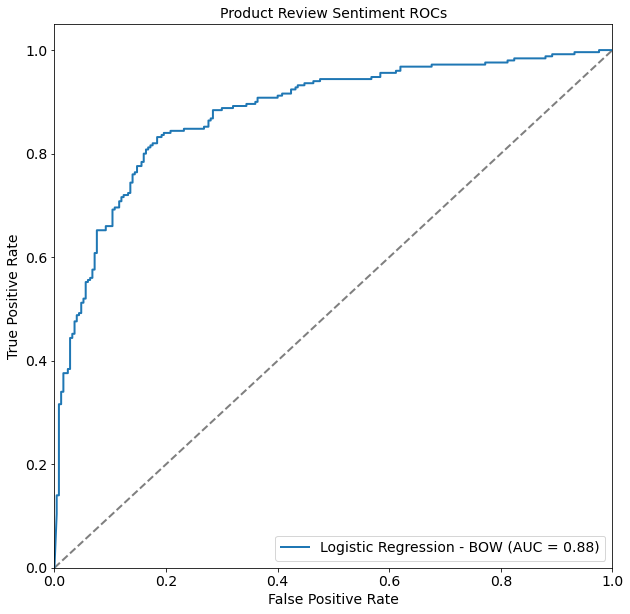

In [19]:
# create a single ROC curve for the One-Hot encoded logistic regression sentiment model
roc_1hot, auc_1hot = get_roc_curves(test_labels, preds_test_probs,
                                    model_names=['Logistic Regression - BOW'],
                                    plot_title='Product Review Sentiment ROCs')
roc_1hot.show()

### Figure 5.

My personal preference is to start with a simple and **interpretable** model to serve as a baseline for comparison before getting into the more sophisticated models. The model we just built will serve this purpose.

## Interpretation of BOW Coefficients

We used a **BOW** representation in order to vectorize each sentiment. For such a simple representation, this does a pretty decent job, but how do we interpret this model?

<font style="font-size:18px">DQ4: Think back to our earlier question about the pros and cons of the _one-hot encoded (1HE) inputs_.
<br>
<br>
a) In general, how many features will we have for models built like this?
<br>
<br>
b) What does each coefficient represent?</font>
<br>
<br>
Now that we have a BOW-based version, we'll work on building the same model but using word embeddings.  But before we do that, lets review some of the relevant concepts around representation and unsupervised learning techniques.

## Alternative Representation:  Word Embeddings (WE's) 

How does a word embedding vector compare to a one-hot encoded word vector?  We know what the later looks like: a single 1 in one location and 0 everywhere else.  Let's take a look at what a word embedding looks like.

For the code below to work, you need to download the GloVe (canned) embeddings from the link provide in the **Reference** section below (ref 5.) into the same directory as your notebook or else set the **DIR** parameters below accordingly.

In [20]:
import os
import sys

BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100  # there are 4 sizes: 50, 100, 200 and 300


def get_embeddings(glove_dir = GLOVE_DIR, emb_dim = EMBEDDING_DIM, enc = "utf8"):
    """
    Reads in and returns a specified set of embeddings.
    
    Args:
        glove_dir(str): directory containing the GloVe embeddings
        
        emb_dim(int): dimensions of the embeddings to read in, valid values: 50, 100, 200, 300
        
        enc(str): encoding used to read the embeddings file, default = "utf8"
    
    
    Returns(dict): a dictionary with keys that are words in the embeddings vocabulary
    and values that are emb_dim-dimensional embedding vectors for those words
    
    """

    print('Indexing word vectors.')
    # load the embeddings into a dict with keys that are words and
    # values are the embedding vectors for those words
    embedding_index = {}

    with open(os.path.join(glove_dir, 'glove.6B.' + str(emb_dim) + 'd.txt'), encoding=enc) as f:
        for line in f:
            word, coeffs = line.split(maxsplit = 1)
            coeffs = np.fromstring(coeffs, dtype='float', sep=' ')
            embedding_index[word] = coeffs
        
    print("Found {} word vectors.".format(len(embedding_index)))
    
    return embedding_index

In [21]:
embeddings = get_embeddings()

Indexing word vectors.
Found 400000 word vectors.


In [22]:
# check out a few of the items that we have embeddings for, verify embedding type and shape
embedding_keys = list(embeddings.keys())
embedding_keys[0:5], type(embeddings['the']), embeddings['the'].shape  # keys are words that have canned embeddings

(['the', ',', '.', 'of', 'to'], numpy.ndarray, (100,))

### Vocabulary Embeddings

As we saw above, our GloVe download contains embeddings for 400,000 tokens (words and punctuation).  Since we have defined our vocabulary to be much smaller than this, we'll use the function below to create a dict of embeddings for just the items in our vocabulary so we aren't slinging around a bigger set of embeddings than we need to.

In [23]:
def get_vocab_embeddings(embedding_index, voc = vocab):
    """
    Gets the embeddings for the words in a vocabulary
    
    Args:
        embedding_index(dict): a dictionary with keys that are words in the
        embeddings vocabulary and values that are embedding vectors for those words
        
        voc(list(str)): list of words that we want embeddings for
    
    
    Returns(tuple): 2-tuple where the first element is a dict of vocabulary word
    keys and embedding vector values. The second element is a list of the words
    that were not found in the embedding_index dict sorted in alphabetical order
    
    """

    # get embeddings for just the words in our vocabulary
    voc_embeddings = {}
    no_embeddings = []
    for word in voc:
        emb = embedding_index.get(word, None)
        if type(emb) == np.ndarray:
            voc_embeddings[word] = embedding_index.get(word, None)
        else:
            no_embeddings.append(word)
#         print("No embedding for {}".format(word))
    
    return voc_embeddings, sorted(no_embeddings)

In [24]:
vocab_embeddings, missing_words = get_vocab_embeddings(embeddings, vocab)
words_found = len(vocab_embeddings)
words_missing = len(missing_words)
print("got embeddings for {} out of {} words in our vocabulary. Missing {}".format(words_found,
                                                                                   len(vocab),
                                                                                   words_missing))

got embeddings for 4374 out of 4500 words in our vocabulary. Missing 126


In [25]:
# which words are missing?
missing_words[0:5]  # names and funny mispellings

['aailiyah', 'absolutel', 'absolutley', 'accessable', 'accessoryone']

In [26]:
# What does the embedding for 'the' look like?
vocab_embeddings['the'], len(vocab_embeddings['the'])  # 100 real numbers

(array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  0.70565

## 100 Dimensional Vector of Reals vs. 4500 Dimensional One-Hot Vector

###  What kind of information might we want the vector of reals to contain?

How about similar words having vectors that are similar?  The function below computes the nearest neighboring word in the vocabulary.

In [27]:
def word_NN(w, vocab_embeddings):
    """
    Finds the word closest to w in the vocabulary that isn't w itself.
    
    Args:
        w(str): string, word to compute nearest neighbor for - must be in a key in vocab_embeddings
        vocab_embeddings(dict): dictionary with keys that are words in the vocabulary
          and values that are d-dimensional numpy array of floats that are the real-
          vector embeddings for each word in the vocabulary
          
    Returns:
        string: the word in the vocabulary that is the closest to this particular word
    
    """
    
    vocab_words = set(vocab_embeddings.keys())
    # check if the word passed in is in the vocabulary
    if not(w in vocab_words):
        print ("Unknown word")
        return
    
    # remove the word we are looking for the nearest neighbor of
    vocab_words.discard(w)
    vocab_words = list(vocab_words)
    
    # get the embedding for passed in word
    w_embedding = vocab_embeddings[w]
    neighbor = 0
    curr_dist = np.linalg.norm(w_embedding - vocab_embeddings[vocab_words[0]])
    # iterate through all the words in the vocabulary and find the 'closest'
    for i in vocab_words:
        dist = np.linalg.norm(w_embedding - vocab_embeddings[i])
        if (dist < curr_dist):
            neighbor = i
            curr_dist = dist
            
    return neighbor

### Do similar word embeddings equate to similar word semantics?

Let's try a few.

In [28]:
# vocab_words.index('money')  # 60
word_NN('money', vocab_embeddings)

'cash'

In [29]:
word_NN('bought', vocab_embeddings)

'sold'

In [30]:
word_NN('loved', vocab_embeddings)

'liked'

In [31]:
word_NN('above', vocab_embeddings)

'below'

In [32]:
vocab_list = sorted(list(vocab_embeddings.keys()))
vocab_list[0:10], vocab_list.index('above')

(['abandoned',
  'abhor',
  'ability',
  'able',
  'abound',
  'about',
  'above',
  'abroad',
  'absolute',
  'absolutely'],
 6)

### Using Word Embeddings For Classification

Word Embeddings are typically used with neural networds when doing classification.  They are not normally used in logistic regression models because we can't account for the sequence of words easily and it's tricky to properly represent documents without losing a lot of information.

Nonetheless, we'll give this a try and see how it works and then compare our results the bag-of-words (BOW) model we built earlier.  We'll need to first figure out how to represent documents using word embeddings.  References 6 and 7 below suggest that using a concatenated vector of coordinate-wise minimums and maximimums works well, so we'll give this a try with 300-dimensional embeddings instead of the 100-dimensional embeddings we were using earlier for illustration purposes.  The means that each document will be represented by a vector in $\mathbb{R}^{2d}$ or $\mathbb{R}^{600}$.  We'll draw some pictures so we can get a clear understanding of what's going on.

### Representing Document as Vectors

If we wrote each d-dimensional word embedding in a document of $n$ words as a column vector and stacked them horizontally, we would form the following $d \times n$ matrix:

<img src="./graphics/doc2vec01a.png">

#### Figure 6.  Document represented as a matrix of embedding vectors

The graphic above represents a document as a $d \times n$ matrix, but what we need is a representation of a document as a **vector**.  We'll do this by collapsing all $n$ columns in this matrix into a single column by first taking **coordinate minimums** which are the minimums of each row.  We'll then do the same, but take **coordinate maximums** and then stacking them on top of each other.  When do this, each document $i$ becomes of fixed length vector that looks like this:

<img src="./graphics/doc2vec02c.png">

#### Figure 7.  Feature vector representing a single document derived from matrix described in Figure 6.

Each of these $x_i$ vectors are samples, so we'll need to transpose this vector and stack them horizontally to form our data (feature) matrix which we'll send to our solver.

We'll start the process by reading the 300-dimensional embeddings, pare these back to our vocabulary and then build our feature matrix.  This is also referred to as a _design matrix_.

In [33]:
vocab_embs300 = get_embeddings(glove_dir = GLOVE_DIR, emb_dim = 300, enc = "utf8")
print("size of embeddings vocabulary: {}".format(len(vocab_embs300)))
vocab_embs300, missing_embs = get_vocab_embeddings(vocab_embs300, vocab)

Indexing word vectors.
Found 400000 word vectors.
size of embeddings vocabulary: 400000


In [34]:
print("We have {} words in our vocabulary".format(selected_vocab_size))
print("embeddings found for our vocabulary: {}".format(len(vocab_embs300)))
words_not_in_embeddings = selected_vocab_size - len(vocab_embs300)
print("vocabulary words not found in embeddings: {}".format(words_not_in_embeddings))
the_emb = vocab_embs300['the']
print("shape of embeddings read in: {}".format(the_emb.shape))

We have 4500 words in our vocabulary
embeddings found for our vocabulary: 4374
vocabulary words not found in embeddings: 126
shape of embeddings read in: (300,)


### Convert the documents to matrices of embeddings

The function below converts a document to the matrix described in the Figure 6.

In [35]:
def doc2matrix(doc, voc_embs, emb_dims=300):
    """Converts a string (doc) representing a document into a (emb_dims x n)
    matrix of word embeddings where n is the number of words in doc.
    
    Args:
        doc(str): list(str) where each string is a review (document aka doc) consisting of
        space delimited words
        
        voc_embs(dict): dictionary with keys that are the words in the selected vocabulary and
        values that are the emb_dims-dimensional word embeddings for those words.
        
        emb_dims(int): size of the word embeddings used to encode words in voc_embs
    
    Returns:
        numpy.ndarray: emb_dims x n array of floats representing a doc
        
        n is the number of word tokens in doc
    
    """
    doc_words = doc.split()
    raw_doc = np.zeros((emb_dims, 1))
    # build the d x n matrix of embeddings as a raw representation of doc
    for i, word in enumerate(doc_words):
#         print(word)
        if i == 0:
            if word in voc_embs:
                raw_doc = voc_embs[word].reshape(-1, 1)
            else:
                raw_doc = np.zeros((emb_dims, 1))
                
#             print("initializeing raw_doc: {}".format(raw_doc.shape))
            continue
        else:
            # use zero vector for words that have no embedding
            if word in voc_embs:
                word_emb = voc_embs[word].reshape(-1, 1)
#                 print(word_emb, word_emb.shape)
            else:
                word_emb = np.zeros((emb_dims, 1))
            
#         print(raw_doc.shape, " | ", word_emb.shape)
        raw_doc = np.hstack((raw_doc, word_emb))
        
        
    return raw_doc


In [36]:
# iterate through each review, convert to Figure 6. matrices and store in a list
docs_as_matrices = []
for sent in sents_processed:
    sent_matrix = doc2matrix(sent, vocab_embs300, 300)
    docs_as_matrices.append(sent_matrix)

In [37]:
print("review strings/docs processed: {}".format(len(docs_as_matrices)))
print("first review text: {}".format(sents_processed[0]))
print("shape of the first review: {}".format(docs_as_matrices[0].shape))
print("top left corner of first review matrix: \n{}".format(docs_as_matrices[0][0:3, 0:3]))

review strings/docs processed: 3000
first review text: so there is no way for me plug in here in us unless go by converter
shape of the first review: (300, 16)
top left corner of first review matrix: 
[[-0.24561  -0.47618  -0.1749  ]
 [ 0.06801   0.069478  0.22956 ]
 [ 0.18254  -0.013086  0.24924 ]]


### Convert the document matrices to single vectors

The function below converts a document matrix described in the Figure 6. into a single coordinate min/max $\mathbb{R}^{600}$ vector described in Figure 7.

In [38]:
def get_x_min_max(doc_as_embs):
    """Creates the coordinate min/max vector representation for a document
    represented as horizontally stacked word embeddings.
    
    Args:
        doc_as_embs (numpy.ndarray): document represented as a d x n matrix
            where d is the size of the word embeddings and n is the number
            of words in the document being represented
    
    Returns:
        numpy.ndarray: real vector column vector of length 2d where d i
        is the size of the word embeddings
    
    """
    
    min_vec = np.amin(doc_as_embs, axis=1).reshape(-1, 1)
    max_vec = np.amax(doc_as_embs, axis=1).reshape(-1, 1)
    x_vec = np.vstack((min_vec, max_vec))
    
    return x_vec

In [39]:
docs_as_matrices[0].shape, docs_as_matrices[1].shape  # should be (embedding dim x number of words in doc)

((300, 16), (300, 4))

In [40]:
def create_emb_feature_matrix(docs_as_matrices):
    """Converts a list of documents matrices as described in Figure 6.
    into a matrix of document vectors with columns described by
    Figure 7.
    
    Args:
        docs_as_matrices (list): list where each element is a (d x w)
            matrix of floats where d is the length of the embeddings
            vectors representing the words in each document and w is
            the number of word tokens in each document
    
    Returns:
        numpy.ndarray: matrix of floats of shape (2d x n) where n is
        the number of input documents that are to be used as inputs
        to the model
        
    """
    
    # iterate through the list of documents represented as embedding vectors and create the min and max vectors
    for i, doc_as_matrix in enumerate(docs_as_matrices):
        x_vec = get_x_min_max(doc_as_matrix)
#      print(i, x_vec.shape)
        if i == 0:
            x_features = np.copy(x_vec.T)
#             print("intialize x_feature: {}".format(x_features.shape))
        else:
            x_features = np.vstack((x_features, x_vec.T))
#             print("vstack x_feature: {}".format(x_features.shape))
    
    return x_features



In [41]:
x_feats = create_emb_feature_matrix(docs_as_matrices)
x_feats.shape  # should be (doc count x (2 x embedding dim))

(3000, 600)

## Build Model With New Features

We'll use the same data to train and test another model from WE inputs. Below we'll repeat the same train/test split as we did for the first model, but using the embeddings form of the inputs

In [42]:
train_data_embs = x_feats[train_inds,]
train_labels_embs = y[train_inds]

test_data_embs = x_feats[test_inds,]
test_labels_embs = y[test_inds]

print("train data: ", train_data_embs.shape)
print("test data: ", test_data_embs.shape)

train data:  (2500, 600)
test data:  (500, 600)


In [43]:
## fit logistic classifier on training data: minimize neg log likelihood ("log"), no regularization penalty
clf_embs = SGDClassifier(loss="log", penalty="none")
clf_embs.fit(train_data_embs, train_labels_embs)

## Pull out the parameters (w,b) of the logistic regression model
w_embs = clf_embs.coef_[0,:]
b_embs = clf_embs.intercept_

## Get predictions on training and test data
preds_train_embs = clf_embs.predict(train_data_embs)
preds_test_embs = clf_embs.predict(test_data_embs)

## Compute errors
errs_train_embs = np.sum((preds_train_embs > 0.0) != (train_labels_embs > 0.0))
errs_test_embs = np.sum((preds_test_embs > 0.0) != (test_labels_embs > 0.0))

print("Training error: ", float(errs_train_embs)/len(train_labels_embs))
print("Test error: ", float(errs_test_embs)/len(test_labels_embs))

Training error:  0.1156
Test error:  0.228


In [44]:
preds_test_probs_glove = clf_embs.predict_proba(test_data_embs)[:,1]

In [45]:
preds_test_probs_bow_v_glove = np.hstack((preds_test_probs.reshape(-1,1),
                                          preds_test_probs_glove.reshape(-1,1)))
preds_test_probs.shape, preds_test_probs_glove.shape, preds_test_probs_bow_v_glove.shape

((500,), (500,), (500, 2))

DEBUG get_roc_curves: BEFORE expanding y_tests from 1 to 2 columns
DEBUG get_roc_curves: BEFORE expansion, y_tests shape = (500, 1)
DEBUG get_roc_curves: BEFORE expansion, y_expanded shape = (500, 1)
DEBUG get_roc_curves: DURING expansion, i = 0 
DEBUG get_roc_curves: DURING expansion, y_expanded shape = (500, 2) 
DEBUG get_roc_curves: AFTER expansion, y_tests columns = 2 
Comparing 2 models


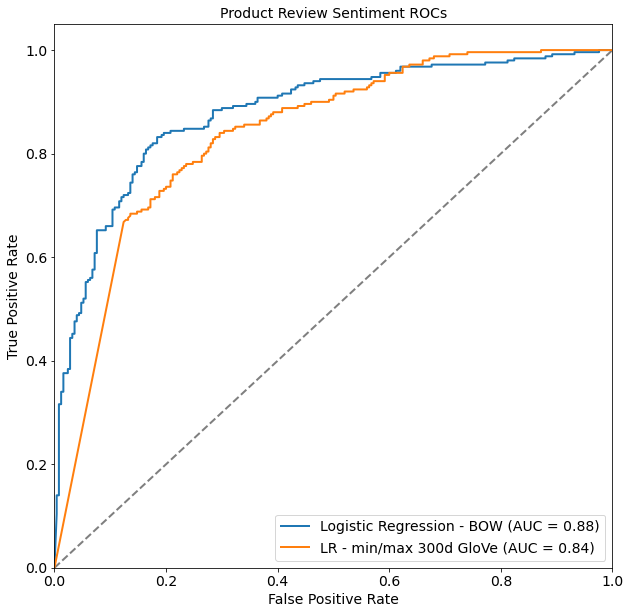

In [46]:
preds_test_probs_bow_v_glove

# create a two ROC curves comparing BOW and WE encoded logistic regression sentiment models
roc_bow_v_glove, auc_1hot = get_roc_curves(test_labels, preds_test_probs_bow_v_glove,
                                           model_names=['Logistic Regression - BOW',
                                                        'LR - min/max 300d GloVe'],
                                           plot_title='Product Review Sentiment ROCs')
roc_bow_v_glove.show()

### Using Word Embeddings as they were intended

The fact that we didn't see any improvement using word embeddings in the way we chose (document min/max) with logistic regression shouldn't have been too surprising because of the way logistic regression works: learning a linear decision boundary

We could probably do better if we continued to experiment with different ways to represent document with the embeddings, but why might we be optimistic about this if logistic regression just learns a linear decision boundary in high-dimensional space?

### Basis Expansion: Linear Dogs Learning Non-Linear Tricks

One straightforward way to introduce non-linearity is by transforming the inputs.  This is easiest seen in the context of regression.  For example, say we have data that looks like this:

<img src="./graphics/parabolic01.png">

We could construct the blue line by fitting the quadratic function $f(x) = w_2x^2 + w_1x + w_0$ by just adding another column of data: $x^2$ and solving for the weights using linear regression.



## Two Main Goals of RL: Vector Quantization & Finding Meaningful Structure in Data

Word embeddings focus primarily on the former (vector quantization) with the later (meaningful structure) in mind.

### Common Clustering Methods

+ k-Mean (covered awhile ago,so we'll do a quick review)
+ PCA (also covered awhile ago, so we'll do a quick review this also)



+ includes (but is not limited to) **dimensionality reduction** 
  + bring out true degree of freedom
+ involves encoding and decoding steps
+ results range from **sparse** to **dense encodings**
+ typical examples: PCA, k-Means, NN-auto-encoders

## Unsupervised Learning

## k-Means Review

+ Simpliest unsupervised learning algorithm
+ Results differ depending on initial choice of centers (means)
+ Multiple methods for center intialization
  + randomly chose all centers from uniform distribution
  + randomly chose extra centers, the prune later
  + k-means++
    + chose first center from uniform distribution
    + let $C = {x}$ centers chosen so far
    + pick successive centers from distribution $Pr(x) \propto dist{(x, C)}^2$
      + probability of chosing next center increases as you move away from existing centers
+ Results in a **sparse** encoding (more on this later) - just the labels
+ The good:
  + Fast and easy
  + Effective in quantization
+ The bad:
  + Spherical clusters of the same radius

Basic algorithm:

1. Choose k
2. Initialize k-centers: $\mu_1,..., \mu_k$  
  + There are several ways to do this. Simpliest is chosing them randomly.
3. Assign each point to its closest center
4. Update each $\mu_j$ to the mean of the points assigned to it.
5. Repeat 3. and 4. until the $\mu_j$ values don't move anymore


<font color="blue" style="font-size:18px">Graphically, the first 2 iterations of the algorithm looks like this on a small dataset with k = 3</font>:
<img src="./graphics/04 kmeans_4steps.png" width="600" height="400">

**<font color="red" style="font-size:18px">Why reduce the number of features in a data set?</font>**

1. reduces storage and computation time
2. high-dimensional data often has a lot redundancy
3. removing noisy and/or irrelevant features improves model accuracy



**<font color="green" style="font-size:16px">Example: are all the pixels in an image informative?</font>**

<img src="./graphics/01 informative pixels.jpg">

### PCA Review - Eliminating low variance coordinates

It took me a couple of revists before getting truly comfortable with **Principal Component Analysis** (PCA), but it was worth the effort because it's one of the most important tools to have in your Data Science toolbox.

PCA is based on chosing the highest variance directions in which to project your data onto.  This is accomplished by computing the eigenvalue and accompanying eigenvectors

projection directions based on the **covariance matrix** of the data. This matrix allows us to contrast the effect of picking **coordinate** directions (i.e. pixels) versus **eigenvector** directions. In particular:

* *The ith **diagonal entry** of the covariance is the variance in the ith coordinate (the ith pixel).*
* *The ith **eigenvalue** of the covariance matrix is the variance in the direction of the ith eigenvector.*

### Why project data onto another direction?  A one dimensional example

<img src="./graphics/02 a 1d example.jpg">

If two variables are correlated, doesn't knowing one inform you of the other?  If so, most of the information is contained along the **projection** in the direction of maximimum variation.

### How do we find this "best" direction to project onto?

<img src="./graphics/03 first eigenvector of covar.jpg">

<font style="font-size:18px">By </font> <font color="green" style="font-size:18px"> "best" </font><font style="font-size:18px">we mean the direction of maximum variance</font>

<font style="font-size:18px">DQx. Why would we want to compute eigenvectors from covariance matrix?</font>

<font style="font-size:18px">DQy. What do we mean by the "first eigenvector of the covariance matrix"?</font>

<font style="font-size:18px">DQz. What would the second eigenvector of the covariance matrix look like for the data shown above?</font>

### Discussion Answers

**DQ1.** Start by writing the formulation of the likelihood:  $\Pi^n_{i=1} Pr_{w,b}(y_i | x_i)$  which is what we want to **maximize**.  We typically turn it into a **minimization** problem by taking the natural log and then the negative of that.  We then search for the minimum of the **negative log-likelihood** using gradient descent to find a solution.  Because this problem is **convex**, we are gauranteed to find a solution.

**DQ2.**  In a real-world scenario, you would collect these reviews from an available source, but often times these reviews are not labeled "positive" or "negative".  When this is the case, you have to read through the reviews yours and assign labels.

E-Bay get around this by having the user click a radio button that identifies the review.  This is a good idea as it can save a lot time down the road.

**DQ3.** 1) No word context or language structure is accounted for. E.g. "The dog bit Johnny." and "Johnny bit the dog." use the same 4 words, but have very different meanings (especially if you're Johnny or the dog).
<br><font style="color:white">**DQ2.** </font>2) Sparse representations are generally require a lot of memory and computation to process (see reference 1. below)

**DQ4.** a) We'll have a coefficient for each word in our defined vocabulary plus 1 for the bias term or $|V| + 1$.<br><br>b) Each coefficient represents the relative importance of that words contribution to the probability that the document has a positive sentiment.<br><br>More specifically, a negative coefficient implies that the more prevelant this word is in a document, the **lower** the probability that the sentiment will be positive. Similarly, a positive coefficient implies that the more prevelant this word is in a document, the **higher** the probability that the sentiment will be positive.

**DQx.** For covariance matrix $\Sigma$ of d-dimensional data $X$, the variance of $X$ in the direction of $u$ is given by $u^T \Sigma u$.  $u^T \Sigma u$ is maximized by setting $u$ to the first **eigenvector** of $\Sigma$.  The maximum value of this variance is the corresponding **eigenvalue**.

**DQy.** For d-dimensional $X$, the **eigenvalues** of the covariance matrix are the variances of the data projected in the direction of the corresponding **eigenvector**.  So to find first **principal component (PC)**, we compute all $d$ sets of eigenvectors and eigenvalues ($\Sigma u_i = \lambda_i u_i$ for i = 1 to d) and then find the eigenvector ($u_i$) corresponding the largest eigenvalue ($\lambda_i$)

**DQz**. This would be the line perpendicular to the first **PC** because eigenvectors computed from the covariance matrix form an **orthonormal basis**.

### References

1. I had to spend many hours doing annotations for a recent project.  It's interesing for the first hour or two as you learn about a new domain, but can get rather mind-numbing after that.
2. [A Gentle Introduction to Sparse Matrices for Machine Learning](https://machinelearningmastery.com/sparse-matrices-for-machine-learning/)
3. [tf-idf on Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
4. ROC reference - TODO
6. [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
  +  Jeffrey Pennington, Richard Socher, Christopher D. Manning
  + Pre-trained word vectors where obtained [here](http://nlp.stanford.edu/data/glove.6B.zip)
7. [Apply word embeddings to entire document, to get a feature vector](https://stats.stackexchange.com/questions/221715/apply-word-embeddings-to-entire-document-to-get-a-feature-vector/)
8. [Representation learning for very short texts using weighted word embedding aggregation](https://arxiv.org/pdf/1607.00570.pdf)
9. [Keras Project - Pre-trained word embeddings example](https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)